<a href="https://colab.research.google.com/github/nicikess/hsg-ml-course/blob/main/notebooks/ml_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [509]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [510]:
import os
import glob
#import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

import rasterio
from rasterio.plot import reshape_as_image

#from tqdm import tqdm
#from tqdm.notebook import tqdm
#import seaborn as sns

from datetime import datetime

from tifffile import imread

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor
#rom torchvision.utils import make_grid
#import torch.nn.functional as F

In [511]:
ROOT_PATH = '/content/drive/MyDrive/ML/'
BASE_PATH = os.path.join(ROOT_PATH, 'data')
DATA_PATH = os.path.join(ROOT_PATH, 'dataset')
MODEL_PATH = os.path.join(ROOT_PATH, 'model')

file_path = '/content/drive/MyDrive/ML/data/dataset/train.csv'

data_df = pd.read_csv(file_path)

data_df.columns = data_df.columns.str.replace('path', 'image_id')
data_df.columns = data_df.columns.str.replace('Label', 'label')

print(data_df.columns)

#data_df = data_df.iloc[0]

data_df.head()

Index(['image_id', 'label'], dtype='object')


,image_id,label
0,AnnualCrop/AnnualCrop_135.tif,AnnualCrop
1,AnnualCrop/AnnualCrop_692.tif,AnnualCrop
2,AnnualCrop/AnnualCrop_2218.tif,AnnualCrop
3,AnnualCrop/AnnualCrop_2679.tif,AnnualCrop
4,AnnualCrop/AnnualCrop_926.tif,AnnualCrop


In [512]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [513]:
IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1

In [514]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, labels in dl:
        print(images.shape)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [515]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0, 1))
    upper_perc = np.percentile(band_data, 98, axis=(0, 1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

In [516]:
from pathlib import Path
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img_class = img_id.split('.')[0].split('_')[0]
        img_id = img_id.split('.')[0]+'.tif'
        path = os.path.join(self.train_dir, img_id)
        with rasterio.open(path, "r") as r:
          img = r.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
          img = img.astype("int64")
        img = reshape_as_image(img)
        normalized_img = normalize_for_display(img)
        img_rgb = normalized_img[:, :, [3,2,1]]
        #if self.transform:
            #img = self.transform(img)
        return img_rgb, encode_label(label)

In [517]:
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

train_ds = EuroSAT(data_df, BASE_PATH, data_transform)
print(len(train_ds))

27000


torch.Size([64, 64, 64, 3])


TypeError: ignored

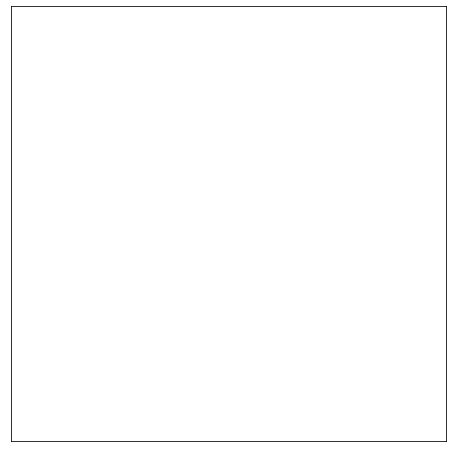

In [529]:
## Data loaders and showing batch of data
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
show_batch(train_dl)

Model

In [519]:
class ChallengeModel(nn.Module):
  
  def __init__(self):
    
    super(ChallengeModel, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.linear1 = nn.Linear(16 * 13 * 13, 240, bias=True) # the linearity W*x+b
    self.relu1 = nn.ReLU(inplace=True) # the non-linearity

    self.linear2 = nn.Linear(240, 120, bias=True) # the linearity W*x+b
    self.relu2 = nn.ReLU(inplace=True) # the non-linarity

    self.linear3 = nn.Linear(120, 84, bias=True) # the linearity W*x+b
    self.relu3 = nn.ReLU(inplace=True) # the non-linarity

    self.linear4 = nn.Linear(84, 10, bias=True) # the linearity W*x+b

    self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax

  def forward(self, images):
    
    x = self.pool1(self.relu1(self.conv1(images)))

    x = self.pool2(self.relu2(self.conv2(x)))

    x = x.view(-1, 16 * 13 * 13)

    x = self.relu1(self.linear1(x))

    x = self.relu2(self.linear2(x))

    x = self.relu3(self.linear3(x))

    x = self.logsoftmax(self.linear4(x))
    
    return x

In [520]:
model = ChallengeModel()

In [521]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


In [522]:
model = model.to(device)

In [523]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

In [524]:
nll_loss = nll_loss.to(device)

In [525]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [526]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

In [527]:
#cifar10_train_dataloader = torch.utils.data.DataLoader(train_dl, batch_size=mini_batch_size, shuffle=True)

In [530]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the CIFAR10 model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dl):
        images = images.permute(3, 0, 1, 2)
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # set filename of actual model
    model_name = 'challenge_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

RuntimeError: ignored

Visualize training loss per epoch

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Evaluation

In [ ]:
# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'cifar10_model_epoch_19.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = CIFAR10Net()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

In [ ]:
# set model in evaluation mode
best_model.eval()

In [ ]:
cifar10_eval_dataloader = torch.utils.data.DataLoader(cifar10_eval_data, batch_size=10000, shuffle=False)

In [ ]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(cifar10_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

Sample prediction

In [ ]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
cifar10_eval_image, cifar10_eval_label = cifar10_eval_data[image_id]

True class of image

In [ ]:
cifar10_classes[cifar10_eval_label]

Inspect the image

In [ ]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(cifar10_classes[cifar10_eval_label])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Compare true label with prediction

In [ ]:
cifar10_eval_image.unsqueeze(0).shape
best_model(cifar10_eval_image.unsqueeze(0))

Obtain all the predictions

In [ ]:
predictions = torch.argmax(best_model(iter(cifar10_eval_dataloader).next()[0]), dim=1)

Overall classification accuracy

In [ ]:
metrics.accuracy_score(cifar10_eval_data.targets, predictions.detach())

Heatmap

In [ ]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(cifar10_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('CIFAR-10 classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');